# Persistent Homology KNN Demo

## Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
from simplicial_complex import SimplicialComplex
from persistent_homology_knn import PHKnn
from ripser_radii import select_radii


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## Visualization Functions

In [2]:
def draw(G):
    segs = []
    for node in G:
        for neb in list(G[node]):
            segs.append([node[0:2], neb[0:2]])

    lc = LineCollection(segs, color=(0,0,0, 0.25))

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.add_collection(lc)
    ax.autoscale()

    ax.scatter(*zip(*list(G)))
    
def draw3d(G):
    segs = []
    for node in G:
        for neb in list(G[node]):
            segs.append([node[0:3], neb[0:3]])
    lc = Line3DCollection(segs, colors=(0,0,0, 0.25))

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(projection = '3d')
    ax.add_collection(lc)
    
    s = list(zip(*list(G)))
    xs = s[0]
    ys = s[1]
    zs = s[2]
    
    ax.set_xlim([min(xs), max(xs)])
    ax.set_ylim([min(ys), max(ys)])
    ax.set_zlim([min(zs), max(zs)])
    
    ax.scatter(*zip(*list(G)))

## Simplicial 1-Complex Object

Simplicial 1-Complexes made up of 0 and 1 dimensional simplices can be completely specified by a connectivity graph:
- 0-simplicies are the vertices
- 1-simplices are the edges of the graph.

The graph is constructed form a set of points and a radius $r$. The radius specficies the resolution at which we view the connectivity of our data: if two points lie within $2r$ of each other, then the two points are connected via an edge. Different metrics can specify different equidistant sets and therefore change the connectivity of the graph. A Simplicicial 1-complex on n points can then be defined as a set of $n$ pairwise connected points.

In the `SimplicialComplex` object, we can import the set of points in the complex and specify a radius. This is enough to create a simplicial 1-complex. 

The simplicial complex is stored in memory as a `networkx` undirected, weighted graph as `SimplicialComplex.complex` (with distance between nodes acting as the weights). Thus, we can conduct graph operations on the complex. The `SimplicialComplex` object acts as a wrapper to a `networkx` graph, with added logic to ensure that the nodes and weights remain faithful to a representation of a simplical 1-complex.

A useful graph operation to conduct might be the `networkx.draw` function, which gives us a visual representation of our complex as a graph. Additionally, we have defined better visualization functions above to visualize the graphs:

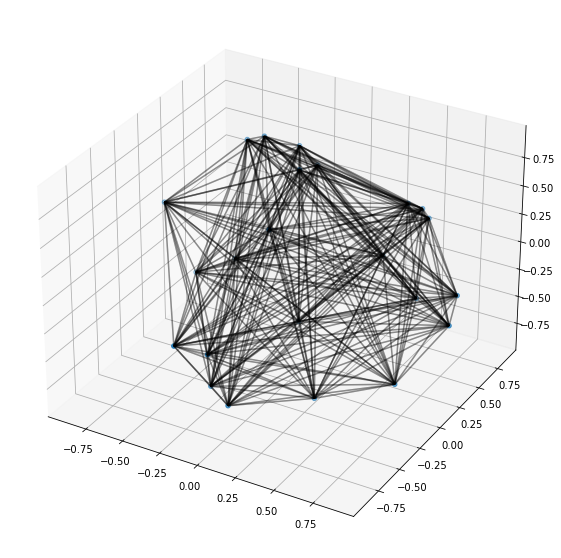

In [3]:
#import data as numpy array
with open('../Data/sparse_sphere_points.txt') as f:
    data = np.loadtxt(f, delimiter=',')

#create simplicial complex object
sc = SimplicialComplex(radius=1,
                       vertices=data)
draw3d(sc.complex)

As hinted at earlier, the distance between two points need not be the standard euclidean distance. With the `graph_distance_metric` parameter, we can give `SimplicialComplex` a new distance metric to determine connectivity in the graph (the default value of this parameter is the euclidean distance). The only requirements are that the metric take two numpy arrays as output and return a scalar value. This mirrors the sentiment that you should be anble to construct a Vietoris-Rips complex using any filter function. For example, consider the taxicab metric below, and notice how this changes our simplicial representation of the same point cloud:

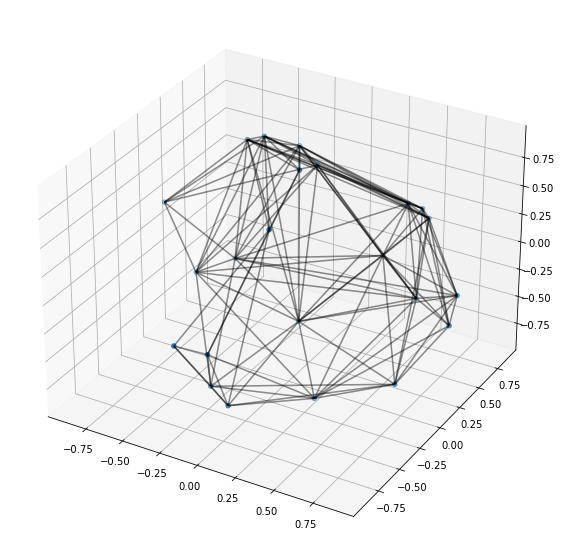

In [4]:
taxicab  = lambda x,y: np.sum(np.abs(x-y))
sc_taxi = SimplicialComplex(radius=1, vertices=data, graph_distance_metric=taxicab)
draw3d(sc_taxi.complex)

Also, we can always add or remove vertices from the complex:

In [5]:
new_point = np.array((1,1,1))
sc.add_point(new_point)
sc.has_point(new_point)

True

In [6]:
sc.remove_point(new_point)
sc.has_point(new_point)

False

Eventually we would like to conduct KNN using metrics that are induced by paths in a simplical representation of our data. In particular, we want paths that respect important topological features in our space. 

For now, we only consider simplicial 1-complexes, but there is certainly to increase to arbitrary k-complexes. The geometry of these representatons should be exploited, in order to approximate geodesics in our space. Thus is will become important to have the weights between nodes be different from the distance used to determine connectivity. We do this by specifying `weight_distance_metric`, which by default equals `graph_distance_metric`. Thus, `graph_distance_metric` determines the connectivity between points and `weight_distance_metric` specifies the weight of the edge between them, eventually allowing us to encode paths through our complex that can approximate geodesics for the original point cloud.

Now, using persistent homology, we investigate the following question: how do you know which choice of radius will produce the right simplicial 1-complex?

## Choosing Radius using Persistence Homology

The state of the art software for generating persistence diagrams that track simplicial homology of Vietoris-Rips Complexes is called Ripser (Copyright © Ulrich Bauer). There is a lean python wrapper for this code that can generate persistence diagrams called Ripser.py, a subdirectory of scikit-tda. 

The goal of this part of the project is to choose radii based on Ripser's persistence diagrams that preserve topologial features of interest. For instance, if you were sampling data from a circle, you would want to set your radius so that you can observe a cycle (non trivial homology in dimension 1) in the simplicial representation of your point cloud.


`select_radii` in ripser_radii.py is a function that evaluates your persistence diagrams (with homology up to the dimension of your choice) and chooses a list of candidate radii that, along with a distance metric, specify Vietoris-Rips complexes that preserve topological features that persist long enough to be deemed important.



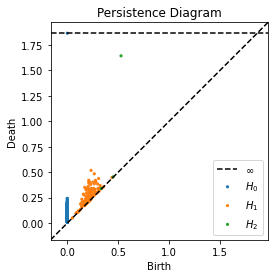

1.0851261913776398

In [7]:
sphere = '../Data/sphere_points.txt'
select_radii(data=sphere,max_dim=2,min_persistence=0.7)

This diagram shows the persistence diagram, as generated by Ripser. An elements distance above the diagonal corresponds directly to its persistence. Here we can see that our sphere data set really has one very prominent feature $H_2$. This corresponds to the volume enclosed by the point cloud, whereas other cycles in $H_1$ are short enough to be ignored. Thus we retain the fact that paths are contractible in the sphere. 

The function has selected a radius that lies within the birth and death of the most prominent feature in $H_2$, and outside the death of the other $H_1$ features.

However, notice the difference when we look at the sparse sampling from a sphere (as pictured above):

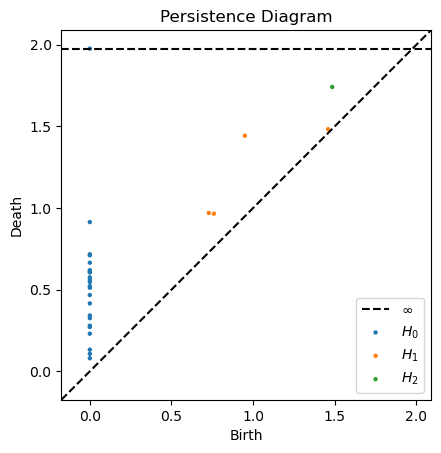

No candidate intervals found. Try decreasing minimum persistence threshold!


In [8]:
sparse_sphere = '../Data/sparse_sphere_points.txt'
select_radii(data=sparse_sphere,max_dim=2,min_persistence=0.7)

The function informs us that our threshold for 'important features' is too high. This is characteristic of sparsely sampled datasets: It is much harder to identify persistent features that are representative of the manifold to which these points embed. So lets decrease the `minimum_persistence` parameter:

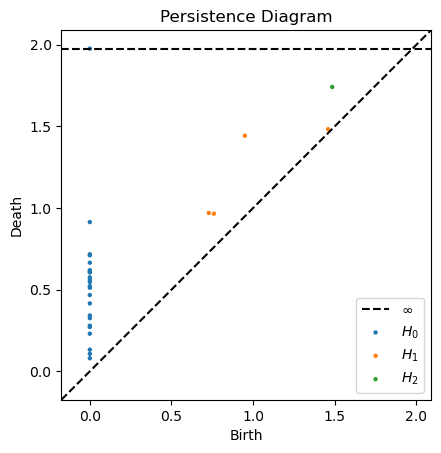

1.1961964666843414

In [9]:
select_radii(data=sparse_sphere,max_dim=2,min_persistence=0.3)

Notice that this has identified the most prominent feature, a cycle in $H_1$. However, due to the lack of information in the dataset, this was not able to achieve the widely accepted homological classification of a sphere. However, clearly from this persistence diagram, it is clear to assume that for this specific point cloud, this cycle is indeed important. Thus our method still seems to be a reasonable approach: most times we won't know the ambient manifold, but we can do our best to approximate the prominent features of the point cloud given.

## Persistent homology KNN demo

The `PHKnn` object conducts the knn algorithm on distances defined by a simplicial complex, which is itself implemented as a `SimplicialComplex` object. To construct the classifier, we must provide a radius $r$ to define the simplex, a number $k$ to define the number of nearest neighbors to consider, and optionally `graph_distance_metric` and `weight_distance_metric` to define the simplex. The latter two arguments always default to the euclidean distance metric.

### Sphere

In [41]:
#create training data
X = data #Sparse Sphere
y = []
for x in X:
    y.append(random.choice([1,0]))
y = np.array(y)

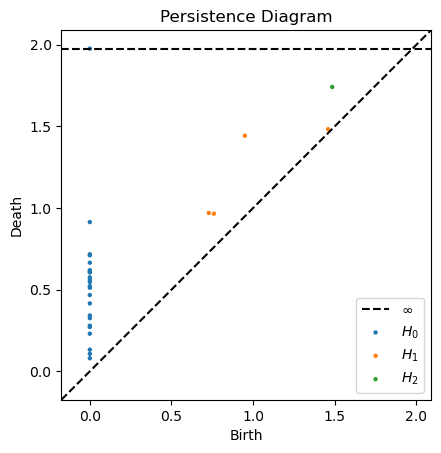

1.1961964666843414


In [42]:
#Choose Radius
radius = select_radii(data=X,max_dim=2,min_persistence=0.3)
print(radius)

In [43]:
classifier = PHKnn(radius=radius, k=5)
classifier.fit(X,y)

To predict using the classifier, we simply provide a numpy matrix of points to classify to the `predict` method:

In [44]:
test = np.array(
    [[1,0,1],
    [0,1,0],
    [-1,-1,-1]])
classifier.predict(test)

[1, 0, 0]

Each entry of the return value corresponds to the point in `test` with the same index. Lets also experiment the radius generated by our denser dataset sampled from a sphere:

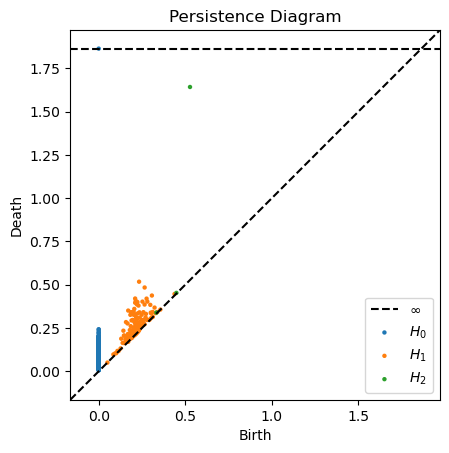

In [45]:
radius = select_radii(sphere,max_dim=2,min_persistence=0.5)
print(radius)

In [46]:
#Fitting Sparse data set with ~more accurate~ radius generated with dense dataset
classifier = PHKnn(radius=radius, k=5)
classifier.fit(X,y)

In [47]:
classifier.predict(test)

[1, 0, 0]

We get the same classification!

This knn method has the important feature that it can fail:

In [52]:
classifier = PHKnn(radius=0.1, k=5)
classifier.fit(X,y)

In [53]:
classifier.predict(test)

Only 1 neighbors to point [1 0 1] found, at least 5 needed for classification.
 This indicates that the data matrix is too sparse near [1 0 1] for a successful classification
Only 4 neighbors to point [0 1 0] found, at least 5 needed for classification.
 This indicates that the data matrix is too sparse near [0 1 0] for a successful classification
Only 1 neighbors to point [-1 -1 -1] found, at least 5 needed for classification.
 This indicates that the data matrix is too sparse near [-1 -1 -1] for a successful classification


[None, None, None]

The neighors to a point are all nodes in the simplicial complex which have a path to the point, if the point were added to the complex. Thus, if the data is too sparse near a point we wish to classify, there simply won't be enough connected components to find $k$ neighbors. This is not necessarily a bad thing, since it can give an indication that:
- We misunderstood the intrinsic geometry of the classification problem. Thus, we need to re-think the distance metrics we use to define the "nearness" of points
- The data is simply too sparse to conduct a classification for a given point and attempting to classify with any algorithm would be misleading. Thus, we should reduce the dimensionality of the data, or collect more data.